# 07 - Modeling Notebook

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelBinarizer

from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, log_loss
from yellowbrick.classifier import ROCAUC


from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.preprocessing import OrdinalEncoder

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

import logging
from datetime import datetime
from datetime import timedelta

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action="ignore", category=DeprecationWarning) 

import sweetviz as sv
import matplotlib.pyplot as plt
import json
import tqdm

In [2]:
import mytransformer as myt

In [3]:
# create the log for this Notebook
now = datetime.now()
filename = 'logs/07-Modeling-' + now.strftime("%m%d%Y") + '.log'

logging.basicConfig(filename=filename ,format='%(asctime)s | %(levelname)s: %(message)s', level=20)
logging.info('')
logging.info('***************************************************************************************************')
logging.info('***                                                                                             ***')
logging.info('***   NEW RUN                                                                                   ***')
logging.info('***                                                                                             ***')
logging.info('***************************************************************************************************')

logging.info('I start to run your Notebook ! -- Good Luck :-) It is:  '+ now.strftime("%m/%d/%Y, %H:%M:%S"))


In [4]:
# folder = '../../data source/_anonymized/'
# declare some constants
folder = '_anonymized/'
sweetviz = True

In [5]:
# read the cleaned csv files

df = pd.read_csv(folder + 'dataset_4_modelling.csv')
try:
    df.drop('Unnamed: 0', axis=1, inplace=True)
except:
    logging.warning('Unnamed: 0 not existing in this file.')
    
logging.info('{} rows and {} columns read in the CSV file'.format(df.shape[0], df.shape[1]))
df.shape

(8902, 63)

# Test the CustomTransformer
The CustomTransformer is importedas a library. The next cells tests the call to the transformation with a sample configuration file.

In [6]:
# Create X and y
X = df.drop('TARGET', axis=1)
y = df.TARGET

# define columns which will passed to transformer for the grouping (brk)
# when applying method such as shift or expanding, I want to maintain the
# fund grouping (or other attribute to set in brk).

brk='SRC_UID'


# Read configuration file
try:
    with open('config_transformation.json') as data_file:
        data_loaded = json.load(data_file)
        trans = data_loaded
except:
    logging.warning('No configuration file found. Create a sample file')
    trans = []
    dico= {}
    dico['cols'] = ['NET_FLOWS']
    dico['method'] = 'shift'
    dico['period'] = [1]
    dico['original'] = True
    trans.append(dico)
    # save the config
    with open('config_transformation.json', 'w') as f:
        json.dump(trans, f)
    
# create the steps and the transformation Pipeline
steps = [('ts_2_supervised',myt.TS2Supervised(transformation=trans, breakdown=brk
                                          , verbose=False, interpolation=True))]
transformation_pipeline = Pipeline(steps)

test_transformed_pipeline = transformation_pipeline.fit_transform(X, y)

In [7]:
new_features = ['SRC_UID','FLOWS_YEAR','FLOWS_MONTH']
new_features =new_features + [x for x in test_transformed_pipeline.columns if 's' in x or 'r' in x or 'e' in x or 'x' in x  ]
test_transformed_pipeline[new_features]

,SRC_UID,FLOWS_YEAR,FLOWS_MONTH,IN_FLOWS-s1,IN_FLOWS-s2,IN_FLOWS-s3,AUM-r2,AUM-r5,AUM-r7
0,206670688,2010,1,69669121.0,69669121.0,69669121.0,713840440.5,654958566.2,6.137747e+08
1,206670688,2010,2,69669121.0,69669121.0,69669121.0,713840440.5,654958566.2,6.137747e+08
2,206670688,2010,3,89408248.0,69669121.0,69669121.0,673792629.5,654958566.2,6.137747e+08
3,206670688,2010,4,68084125.0,89408248.0,69669121.0,634908810.0,654958566.2,6.137747e+08
4,206670688,2010,5,104779215.0,68084125.0,89408248.0,610520193.5,654958566.2,6.137747e+08
...,...,...,...,...,...,...,...,...,...
8897,213479867994200,2020,9,2226192.0,7838181.0,14258055.0,499453583.0,466825279.2,4.407168e+08
8898,213479867994200,2020,10,8479346.0,2226192.0,7838181.0,509903678.0,489066372.0,4.679802e+08
8899,213479867994200,2020,11,14776729.0,8479346.0,2226192.0,547350187.0,516972277.8,4.898324e+08
8900,213479867994200,2020,12,24501245.0,14776729.0,8479346.0,605626878.0,546329817.0,5.223694e+08


# Capstone Project
## Modelling

The modelling will implement classification models from Sklearn and evaluate the prediction. Prior to implement model, I will decide the metrics I will used to evaluate the modelling process.

As in the previous Notebooks I prepared the dataset and created a personal transformer I will use it in the modelling pipeline with some other transformation such as “power transformation”.

The modelling notebook will implement:
1.	Decide metrics
2.	Prepare configuration file for the personal transformer
3.	Split the dataset
a.	Beginning -> 2019 training set
b.	2020 -> validation set
c.	2021 -> test set
4.	Compute a baseline
a.	Baseline will be done on a minimal dataset transformation
5.	Create pipelines
a.	Pre-processing steps
i.	Scaling
ii.	Adding PolynomialFeatures
iii.	OneHotEncoding
iv.	36tEncoding
b.	Custom transformation
c.	Classifiers
6.	Run the modelling step with pipelines
7.	Select the best estimator
8.	Fine tune the best estimator
9.	Run the fine tunned estimator on the test set
10.	Present and discuss the results

Everything will be implemented mostly with scikit learn (https://scikit-learn.org/stable/user_guide.html)
### Metrics
I will work with 6 classification problems metrics to evaluate the performance of the models. Metrics are: Accuracy score, confusion matrix (3x3), Precision, Recall, F1 score and ROC Curve.
1.	https://towardsdatascience.com/a-practical-guide-to-seven-essential-performance-metrics-for-classification-using-scikit-learn-2de0e0a8a040
2.	https://towardsdatascience.com/6-useful-metrics-to-evaluate-binary-classification-models-55fd1fed6a20

#### ROC Curve
The ROC Curve will shows the tru positive rate against the false positive. The perfect classification represented by (0,1) will shows how the model how the model classify positives without missclassifying negative as positive.

For this metrics I installed <i>yellowbrick</i> (https://www.scikit-yb.org/en/latest/) which has a ready to use method for multiclass ROC AUC plots that is very easy.

- https://medium.com/swlh/how-to-create-an-auc-roc-plot-for-a-multiclass-model-9e13838dd3de#:~:text=For%20multiclass%20problems%2C%20ROC%20curves,calculated%20for%20each%20class%20individually.
- https://medium.com/analytics-vidhya/understanding-roc-and-auc-metrics-in-classification-tasks-e5e7594cd6b

### Configuration files for the custom transformer
I will prepare 4 configuration files. The 1st one will be a minimal file to evaluate a simple baseline. It will shift the net flows for 1, 2 and 3 periods.

The other configuration files will be more complicated. 2 will be based on the analysis and recommendation from the EDA Notebooks and the last one will a massive choice of features.

### Split the dataset
I decided to split my dataset in a training set [< 2020], a validation set [=2020] and a test set [=2021]. I will verify the balance of the target data after splitting the dataset.

### Pipelines
In the pipelines I will add pre-processing step, optional steps (as we did in the course) and transformation. I will use a grid search to evaluate multiple configurations of parameters.
1.	https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf

#### Models
•	Logistic Regression (which is a linear model for classification problems).
•	Support Vector Machine: (https://scikit-learn.org/stable/modules/svm.html)
•	Nearest Neighbours Classification: (https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification)
•	Decision Trees Classification: (https://scikit-learn.org/stable/modules/tree.html#classification)
•	Neural Network Models (supervised) Classification: (https://scikit-learn.org/stable/modules/neural_networks_supervised.html#classification)

A meta estimator which fits several decision trees:
•	Random Forest Classifier: (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random%20forest#sklearn.ensemble.RandomForestClassifier)

I will run a grid search over multiple classifiers to elicit the best estimator.
https://stackoverflow.com/questions/23045318/scikit-grid-search-over-multiple-classifiers
### Best estimator, fine tuning, and test set evaluation
At the end of the pipeline process, I will decide the best estimator, fine tune some parameters if needed and evaluate it against un unknown dataset which is the 2021 entry values (almost all Q1 data).





# Split my dataset
I decided to split my dataset as following:

- training set (all data before 2020)
- validation set (all data of 2020)
- test set (all data of 2021)

## Check if split is well distributed
I will check and plot if the data after split are well distributed within the target value.

I define 3 filters which I will apply to the full dataset. Then I will create 3 set and evaluate for each of them the ratio of:
- in flows
- no flows
- out flows

In [8]:
split_df = df.copy()

In [9]:
f_training = split_df.FLOWS_YEAR < 2019
f_validation_1 = split_df.FLOWS_YEAR == 2020
f_validation_2 = split_df.FLOWS_YEAR == 2019
f_test = split_df.FLOWS_YEAR == 2021

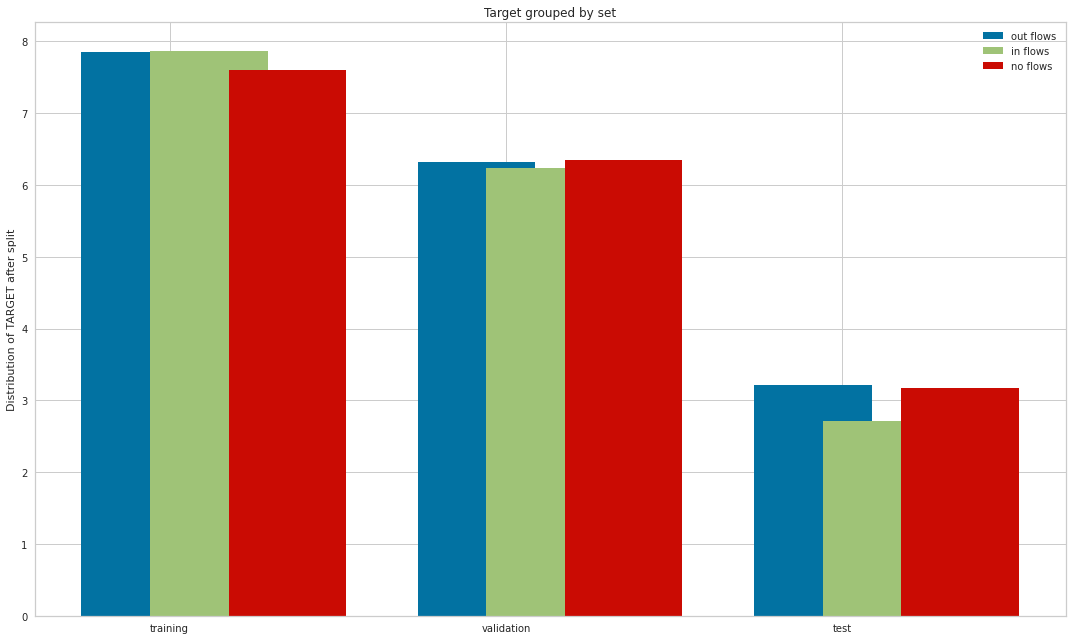

In [10]:
target_distrib = {}
# distribution of test set
(unique, counts) = np.unique(split_df.loc[f_test,'TARGET'], return_counts=True)
frequencies = np.asarray((unique, counts)).T
target_distrib['test']=frequencies
# distribution of validation set
(unique, counts) = np.unique(split_df.loc[((f_validation_1) | (f_validation_2)),'TARGET'], return_counts=True)
frequencies = np.asarray((unique, counts)).T
target_distrib['validation']=frequencies
# distribution of training set
(unique, counts) = np.unique(split_df.loc[f_training,'TARGET'], return_counts=True)
frequencies = np.asarray((unique, counts)).T
target_distrib['training']=frequencies




labels = ['training', 'validation', 'test']
out_flows = np.log([target_distrib['training'][0][1], target_distrib['validation'][0][1], target_distrib['test'][0][1]])
no_flows = np.log([target_distrib['training'][1][1], target_distrib['validation'][1][1], target_distrib['test'][1][1]]) 
in_flows =np.log([target_distrib['training'][2][1], target_distrib['validation'][2][1], target_distrib['test'][2][1]])

x = np.arange(len(labels))  # the label locations
width =0.35 # the width of the bars

fig, ax = plt.subplots(figsize=(15,9))

rects1 = ax.bar(x - width/4, out_flows, width, label='out flows')
rects3 = ax.bar(x + width/3, in_flows, width, label='in flows')
rects2 = ax.bar(x + width/1, no_flows, width, label='no flows')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Distribution of TARGET after split')
ax.set_title('Target grouped by set')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()



fig.tight_layout()

plt.show()

In [11]:
# define a function which will be called to split the dataset
def split_dataset(df):
    split_df = df.copy()
    f_training = split_df.FLOWS_YEAR < 2019
    f_validation = (split_df.FLOWS_YEAR == 2019) | ((split_df.FLOWS_YEAR == 2020) & (split_df.FLOWS_MONTH <=4) ) 
    f_test = (split_df.FLOWS_YEAR == 2021) | ((split_df.FLOWS_YEAR == 2020) & (split_df.FLOWS_MONTH >4) )
    f_trainval = (split_df.FLOWS_YEAR < 2020) & ((split_df.FLOWS_YEAR == 2020) & (split_df.FLOWS_MONTH <=4) )
    
    X_train = split_df.loc[f_training,:].drop('TARGET', axis=1)
    y_train = split_df.loc[f_training,'TARGET']
    
    X_validation = split_df.loc[f_validation,:].drop('TARGET', axis=1)
    y_validation = split_df.loc[f_validation,'TARGET']
    
    X_test = split_df.loc[f_test,:].drop('TARGET', axis=1)
    y_test = split_df.loc[f_test,'TARGET']
    
    X_trainval = split_df.loc[f_trainval,:].drop('TARGET', axis=1)
    y_trainval = split_df.loc[f_trainval,'TARGET']
    '''
    X_train, X_validation, y_train, y_validation = train_test_split(
        X_trainval, y_trainval, test_size=0.33, random_state=42, stratify=y_trainval)    
    '''
    logging.info('dataset split called')
    return X_train, y_train, X_validation, y_validation, X_test, y_test, X_trainval, y_trainval
    

## Split Observation
The split gives balanced set related to the target variables.

# Metrics report
I wite a simple function to display modeling report. The function receive the target value fot the validation set and the predicted value (y_validation, y_pred) and displays results.

In [12]:
def metrics_report(y_validation, y_pred):
    # confusion matrix
    confusion = confusion_matrix(y_validation, y_pred)
    print('Confusion Matrix\n')
    print(confusion)
    logging.info('Confusion Matrix \n {}'.format(confusion))

    # accuracy_score, precision_score, recall_score, f1_score
    print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_validation, y_pred)))
    logging.info('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_validation, y_pred)))

    print('Micro Precision: {:.2f}'.format(precision_score(y_validation, y_pred, average='micro')))
    print('Micro Recall: {:.2f}'.format(recall_score(y_validation, y_pred, average='micro')))
    print('Micro F1-score: {:.2f}\n'.format(f1_score(y_validation, y_pred, average='micro')))

    print('Macro Precision: {:.2f}'.format(precision_score(y_validation, y_pred, average='macro')))
    print('Macro Recall: {:.2f}'.format(recall_score(y_validation, y_pred, average='macro')))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(y_validation, y_pred, average='macro')))

    print('Weighted Precision: {:.2f}'.format(precision_score(y_validation, y_pred, average='weighted')))
    print('Weighted Recall: {:.2f}'.format(recall_score(y_validation, y_pred, average='weighted')))
    print('Weighted F1-score: {:.2f}'.format(f1_score(y_validation, y_pred, average='weighted')))


    print('\nClassification Report\n')
    print(classification_report(y_validation, y_pred, target_names=['Out Flows', 'NeutralFlows', 'In Flows']))
    
    return accuracy_score(y_validation, y_pred), confusion

In [13]:
def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder={-1: 'Out flows', 
                                        0: 'no flows / neutral', 
                                        1: 'in flows'})
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

# Modelling Concept
In the previous Notebooks I explored the data, make a review of the time series and build a CustomTransformer which help to adopt rolling window and other shifting method to transform the TS to a supervised learning dataset.

<b>Time to apply these methods to the modelling steps of my project !</b>

The concept is to extract features from the full dataset and apply Custom Transormation to get a subset of features. This subset will be arranged in a area for the traning/validation process and finally the test set (data that has not been involded in the training and evaluation process).

The the modeling can be applied with different steps such as data pre-processing, features selections, features engineering (power transformation), dimensionality reduction and other method. I will mostly work with pipelines and grid search method.

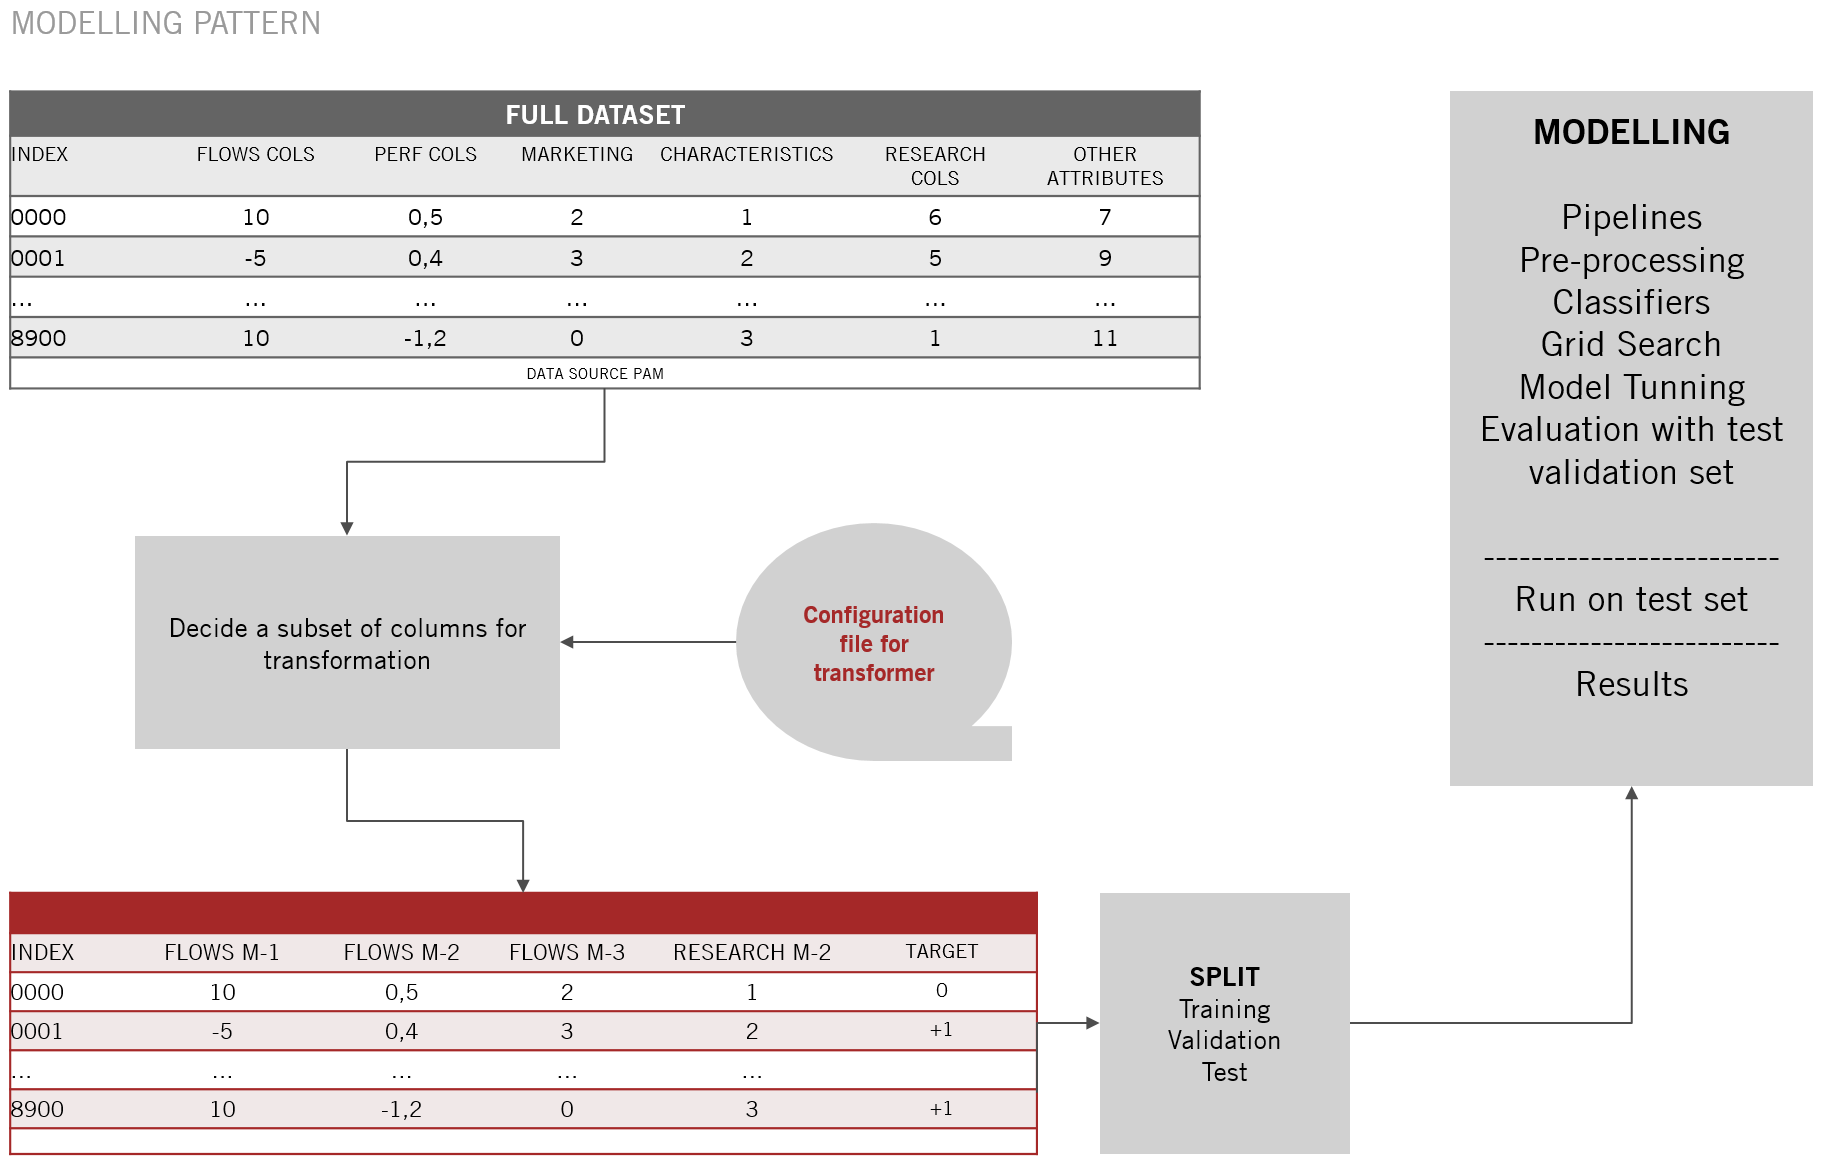

# Baseline
I will compute a baseline by extracting the net flows and apply a custom transformation to shift the feature over 3 periods (m-3, m-2, m-1). In the baseline I will add the nav/benchmark performance slope and nav/bench volatility slope.
As a standard I will always add the <i>flows_yeays</i> and <i>flows_month</i> in the dataset.

In [14]:
# create a temporary dataset for the baseline modelling
# I make a copy of specif columns from the full dataset to a baseline dataset
baseline_features = ['SRC_UID','FLOWS_YEAR','FLOWS_MONTH','BENCH_PERF_SLOPE',
       'BENCH_VOL_SLOPE', 'NAV_PERF_SLOPE', 'NAV_VOL_SLOPE','AUM', 'TARGET']
baseline_df = df[baseline_features].copy()
baseline_df.head()

,SRC_UID,FLOWS_YEAR,FLOWS_MONTH,BENCH_PERF_SLOPE,BENCH_VOL_SLOPE,NAV_PERF_SLOPE,NAV_VOL_SLOPE,AUM,TARGET
0,206670688,2010,1,-0.002294,-0.000033,-0.001929,-0.000154,706167185,-1
1,206670688,2010,2,-0.001882,-0.000032,-0.001646,-0.000127,721513696,1
2,206670688,2010,3,-0.001614,-0.000034,-0.001485,-0.000106,626071563,-1
3,206670688,2010,4,-0.001358,-0.000022,-0.001052,-0.000082,643746057,1
4,206670688,2010,5,-0.001117,-0.000016,-0.000743,-0.000062,577294330,-1


In [15]:
# define the X vector and y target for the new temprary dataset
X = baseline_df.drop('TARGET', axis=1)
y = baseline_df.TARGET

In [16]:
# define the configuration dictionary for the baseline
# I will only shift the NET FLOWS for 3 periods
# Remove the NET_FLOWS columns
trans = []
dico= {}
dico['cols'] = ['BENCH_PERF_SLOPE',
       'BENCH_VOL_SLOPE', 'NAV_PERF_SLOPE', 'NAV_VOL_SLOPE','AUM']
dico['method'] = 'shift'
dico['period'] = [1]
dico['original'] = False
trans.append(dico)

# create the steps and the transformation Pipeline
steps = [('ts_2_supervised',myt.TS2Supervised(transformation=trans, breakdown=brk
                                          , verbose=False, interpolation=False))]
# create
baseline_pipeline = Pipeline(steps)

baseline_transformed_pipeline = baseline_pipeline.fit_transform(X, y)


baseline_df = baseline_transformed_pipeline.merge(baseline_df.TARGET, left_index=True, right_index=True).copy()
baseline_df.dropna(inplace=True)
baseline_df

,SRC_UID,FLOWS_YEAR,FLOWS_MONTH,BENCH_PERF_SLOPE-s1,BENCH_VOL_SLOPE-s1,NAV_PERF_SLOPE-s1,NAV_VOL_SLOPE-s1,AUM-s1,TARGET
1,206670688,2010,2,-0.002294,-0.000033,-0.001929,-0.000154,706167185.0,1
2,206670688,2010,3,-0.001882,-0.000032,-0.001646,-0.000127,721513696.0,-1
3,206670688,2010,4,-0.001614,-0.000034,-0.001485,-0.000106,626071563.0,1
4,206670688,2010,5,-0.001358,-0.000022,-0.001052,-0.000082,643746057.0,-1
5,206670688,2010,6,-0.001117,-0.000016,-0.000743,-0.000062,577294330.0,-1
...,...,...,...,...,...,...,...,...,...
8897,213479867994200,2020,9,0.002128,0.000035,-0.008795,-0.015355,500587973.0,1
8898,213479867994200,2020,10,0.002099,0.000035,-0.017896,-0.001291,498319193.0,1
8899,213479867994200,2020,11,0.002086,0.000063,-0.015975,-0.012080,521488163.0,1
8900,213479867994200,2020,12,0.002108,0.000040,-0.011221,-0.003275,573212211.0,1


In [17]:
X_train, y_train, X_validation, y_validation, X_test, y_test, _, _ = split_dataset(baseline_df)
X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape

((7113, 8), (7113,), (1152, 8), (1152,), (556, 8), (556,))

In [18]:
np.unique(y_train, return_counts=True), np.unique(y_validation, return_counts=True), np.unique(y_test, return_counts=True)

((array([-1,  0,  1]), array([2549, 1984, 2580])),
 (array([-1,  0,  1]), array([399, 400, 353])),
 (array([-1,  0,  1]), array([184, 198, 174])))

###### Create the pipelines with simple scaling and classifiers

In [146]:
# create a pipeline for the baseline
pipelines = []
pipelines.append(('LR', Pipeline([('Scaler', StandardScaler()),('Power', PowerTransformer()),('LR',LogisticRegression(solver='liblinear', random_state=42))])))
# pipelines.append(('SVM', Pipeline([('Scaler', StandardScaler()),('Power', PowerTransformer()),('SVC',SVC(gamma='auto', random_state=42))])))
# pipelines.append(('KNN', Pipeline([('Scaler', StandardScaler()),('Power', PowerTransformer()),('KNN',KNeighborsClassifier())])))
pipelines.append(('TREE', Pipeline([('Scaler', StandardScaler()),('Power', PowerTransformer()),('TREE',DecisionTreeClassifier(random_state=42))])))
# pipelines.append(('FOREST', Pipeline([('Scaler', StandardScaler()),('Power', PowerTransformer()),('FOREST',RandomForestClassifier(random_state=42))])))
# pipelines.append(('MLP', Pipeline([('Scaler', StandardScaler()),('Power', PowerTransformer()),('MLP',MLPClassifier(solver='lbfgs'))])))

In [20]:
def run_pipelines(X_train, y_train):
    # Test options and evaluation metric
    num_folds = 10
    seed = 7
    scoring = 'accuracy'
    
    
    X_train=X_train.astype('float64')
    y_train=y_train.astype('float64')

    results = []
    names = []
    msgs = []

    with tqdm.tqdm(total=len(pipelines)) as pbar:
        for name, model in pipelines:
            try:
                kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
                cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
                results.append(cv_results)
                names.append(name)
                msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
                msgs.append(msg)
                logging.info(msg)
            except:
                logging.warning('UNABLE TO RUN THE CROSS VAL')
            pbar.update(1)
            #print(msg)

    print(msgs)
    return results, names
    
results, names = run_pipelines( X_train, y_train)

100%|██████████| 5/5 [00:33<00:00,  6.64s/it]

['LR: 0.427389 (0.017156)', 'SVM: 0.430760 (0.015104)', 'KNN: 0.435820 (0.010008)', 'TREE: 0.419236 (0.017887)', 'FOREST: 0.452271 (0.022579)']


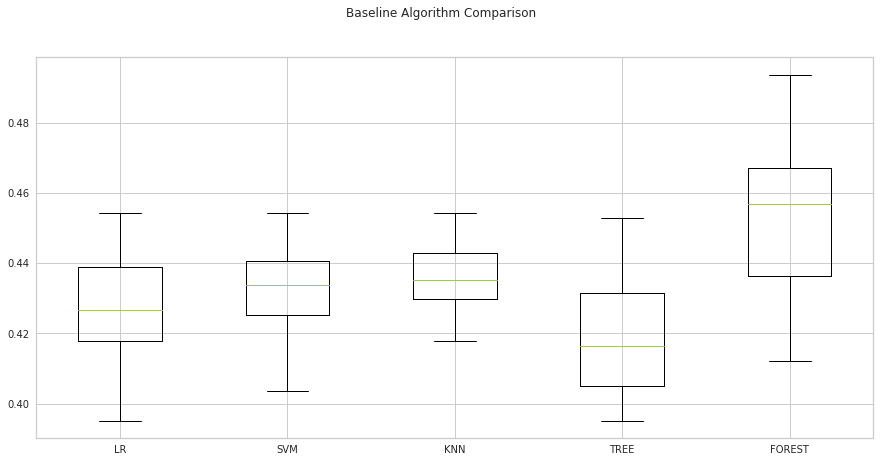

In [21]:
# Compare Algorithms
fig = plt.figure(figsize=(15,7))
fig.suptitle('Baseline Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Baseline observations
Logistic regression, Random Forest and Support Vector Machine give the best baseline results. I will keep all models for next step of modelling exploration because no one is completely out of the range of the result set.

# Model 01
For the 1st model I will work with SelectKBest from sklearn to look for the best features related to the target and build dynamically a transformation dictionary with a <b>rolling</b> method on 3 month (usually a quarter is a good time frame for investors).

In [22]:
df.head(6)

,SRC_UID,IS_STRATEGIC,ADMINSTRATION_FEES,MANAGEMENT_FEES,MULTI_MANAGER_STRUCTURE,SOFTCLOSING,CNT_SHARE,QUANTITY,IN_FLOWS,OUT_FLOWS,...,FLOWS_QUARTER,FUND_AGE,BENCH_PERF_SLOPE,BENCH_PERF_SLOPE_ERROR,BENCH_VOL_SLOPE,BENCH_VOL_SLOPE_ERROR,NAV_PERF_SLOPE,NAV_PERF_SLOPE_ERROR,NAV_VOL_SLOPE,NAV_VOL_SLOPE_ERROR
0,206670688,0,0.000277,0.001631,1,0,12,5389079,69669121,-201496427,...,1,14.646575,-0.002294,0.005912,-0.000033,0.000171,-0.001929,0.004775,-0.000154,0.000694
1,206670688,0,0.000277,0.001631,1,0,12,5504541,89408248,-74310603,...,1,14.723288,-0.001882,0.004867,-0.000032,0.000159,-0.001646,0.003938,-0.000127,0.000652
2,206670688,0,0.000277,0.001631,1,0,12,4781963,68084125,-163602809,...,1,14.808219,-0.001614,0.004224,-0.000034,0.000128,-0.001485,0.003630,-0.000106,0.000647
3,206670688,0,0.000277,0.001631,1,0,12,4910848,104779215,-87141120,...,2,14.890411,-0.001358,0.003621,-0.000022,0.000126,-0.001052,0.002517,-0.000082,0.000607
4,206670688,0,0.000277,0.001631,1,0,12,4408949,65517596,-132116073,...,2,14.975342,-0.001117,0.003113,-0.000016,0.000112,-0.000743,0.001721,-0.000062,0.000610
5,206670688,0,0.000277,0.001631,1,0,12,3937689,43293193,-105390034,...,2,15.057534,-0.000958,0.002837,-0.000011,0.000133,-0.000540,0.001313,-0.000040,0.000655


In [23]:

# define the X vector and y target for the new temprary dataset
features_df = df.drop(['NET_FLOWS','COMPUTED_FLOWS','SRC_UID','THRESHOLD'], axis=1).copy()
target = df.TARGET

X_train, y_train, X_validation, y_validation, X_test, y_test, _, _ = split_dataset(features_df)
X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape

# Create and fit selector
n_features=10
selector = SelectKBest(f_classif, k=n_features)

# selector.fit(features_df, target)
selector.fit(X_train, y_train)
# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)

features_df_new = features_df.iloc[:,cols]
features_df_new

features_df_new=features_df_new.merge(df[['SRC_UID','TARGET']], left_index=True, right_index=True)

cols_config=features_df_new.drop(['SRC_UID','TARGET'],axis=1).columns
features_df_new

X = features_df_new.drop('TARGET', axis=1)
y = features_df_new.TARGET

trans = []
for i in range(len(cols_config)):
    dico= {}
    dico['cols'] = [cols_config[i]]
    dico['method'] = 'shift'
    dico['period'] = [1,2,3]
    dico['original'] = False
    trans.append(dico)
    
trans

In [29]:
trans

[{'cols': ['IN_FLOWS'],
  'method': 'shift',
  'period': [1, 2, 3],
  'original': False},
 {'cols': ['OUT_FLOWS'],
  'method': 'shift',
  'period': [1, 2, 3],
  'original': False},
 {'cols': ['BENCH_PERF_3_MONTH'],
  'method': 'shift',
  'period': [1, 2, 3],
  'original': False},
 {'cols': ['NAV_PERF_1_YEAR'],
  'method': 'shift',
  'period': [1, 2, 3],
  'original': False},
 {'cols': ['NAV_PERF_3_MONTH'],
  'method': 'shift',
  'period': [1, 2, 3],
  'original': False},
 {'cols': ['NAV_PERF_6_MONTH'],
  'method': 'shift',
  'period': [1, 2, 3],
  'original': False},
 {'cols': ['RISK_LEVEL_VALUE'],
  'method': 'shift',
  'period': [1, 2, 3],
  'original': False},
 {'cols': ['FLOWS_QUARTER'],
  'method': 'shift',
  'period': [1, 2, 3],
  'original': False},
 {'cols': ['BENCH_VOL_SLOPE_ERROR'],
  'method': 'shift',
  'period': [1, 2, 3],
  'original': False},
 {'cols': ['NAV_PERF_SLOPE'],
  'method': 'shift',
  'period': [1, 2, 3],
  'original': False}]

In [30]:
# create the steps and the transformation Pipeline
steps = [('ts_2_supervised',myt.TS2Supervised(transformation=trans, breakdown=brk
                                          , verbose=False, interpolation=False))]
# create
kbest_pipeline = Pipeline(steps)

kbest_transformed_pipeline = kbest_pipeline.fit_transform(X, y)


kbest_df = kbest_transformed_pipeline.merge(df[['TARGET','FLOWS_YEAR','FLOWS_MONTH']], left_index=True, right_index=True).copy()
kbest_df.dropna(inplace=True)
kbest_df

,SRC_UID,IN_FLOWS-s1,IN_FLOWS-s2,IN_FLOWS-s3,OUT_FLOWS-s1,OUT_FLOWS-s2,OUT_FLOWS-s3,BENCH_PERF_3_MONTH-s1,BENCH_PERF_3_MONTH-s2,BENCH_PERF_3_MONTH-s3,...,FLOWS_QUARTER-s3,BENCH_VOL_SLOPE_ERROR-s1,BENCH_VOL_SLOPE_ERROR-s2,BENCH_VOL_SLOPE_ERROR-s3,NAV_PERF_SLOPE-s1,NAV_PERF_SLOPE-s2,NAV_PERF_SLOPE-s3,TARGET,FLOWS_YEAR,FLOWS_MONTH
3,206670688,68084125.0,89408248.0,69669121.0,-163602809.0,-74310603.0,-201496427.0,0.000512,0.000512,0.000573,...,1.0,0.000128,0.000159,0.000171,-0.001485,-0.001646,-0.001929,1,2010,4
4,206670688,104779215.0,68084125.0,89408248.0,-87141120.0,-163602809.0,-74310603.0,0.000522,0.000512,0.000512,...,1.0,0.000126,0.000128,0.000159,-0.001052,-0.001485,-0.001646,-1,2010,5
5,206670688,65517596.0,104779215.0,68084125.0,-132116073.0,-87141120.0,-163602809.0,0.000605,0.000522,0.000512,...,1.0,0.000112,0.000126,0.000128,-0.000743,-0.001052,-0.001485,-1,2010,6
6,206670688,43293193.0,65517596.0,104779215.0,-105390034.0,-132116073.0,-87141120.0,0.000730,0.000605,0.000522,...,2.0,0.000133,0.000112,0.000126,-0.000540,-0.000743,-0.001052,-1,2010,7
7,206670688,33504675.0,43293193.0,65517596.0,-41136591.0,-105390034.0,-132116073.0,0.000920,0.000730,0.000605,...,2.0,0.000151,0.000133,0.000112,-0.000382,-0.000540,-0.000743,1,2010,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8897,213479867994200,2226192.0,7838181.0,14258055.0,-912205.0,-586358.0,-1036150.0,-0.001789,-0.001706,-0.001672,...,2.0,0.000088,0.000112,0.000131,-0.008795,-0.004750,-0.002308,1,2020,9
8898,213479867994200,8479346.0,2226192.0,7838181.0,-1279087.0,-912205.0,-586358.0,-0.001782,-0.001789,-0.001706,...,3.0,0.000057,0.000088,0.000112,-0.017896,-0.008795,-0.004750,1,2020,10
8899,213479867994200,14776729.0,8479346.0,2226192.0,-1015792.0,-1279087.0,-912205.0,-0.001791,-0.001782,-0.001789,...,3.0,0.000007,0.000057,0.000088,-0.015975,-0.017896,-0.008795,1,2020,11
8900,213479867994200,24501245.0,14776729.0,8479346.0,-359147.0,-1015792.0,-1279087.0,-0.001801,-0.001791,-0.001782,...,3.0,0.000049,0.000007,0.000057,-0.011221,-0.015975,-0.017896,1,2020,12


In [31]:
X_train, y_train, X_validation, y_validation, X_test, y_test, _, _ = split_dataset(kbest_df)
X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape

((6951, 33), (6951,), (1152, 33), (1152,), (556, 33), (556,))

In [32]:
results, names = run_pipelines(X_train, y_train)
logging.info('MODEL-01 SelectKBest features and rolling 1,2,3 configuration files with {}'.format(n_features))
logging.info('Results: \n\n{}'.format(results))
logging.info('--------------------------------------------------------------------------------------------------')

100%|██████████| 5/5 [01:00<00:00, 12.18s/it]

['LR: 0.496761 (0.014718)', 'SVM: 0.504818 (0.015702)', 'KNN: 0.456479 (0.016564)', 'TREE: 0.425551 (0.015522)', 'FOREST: 0.476191 (0.012379)']


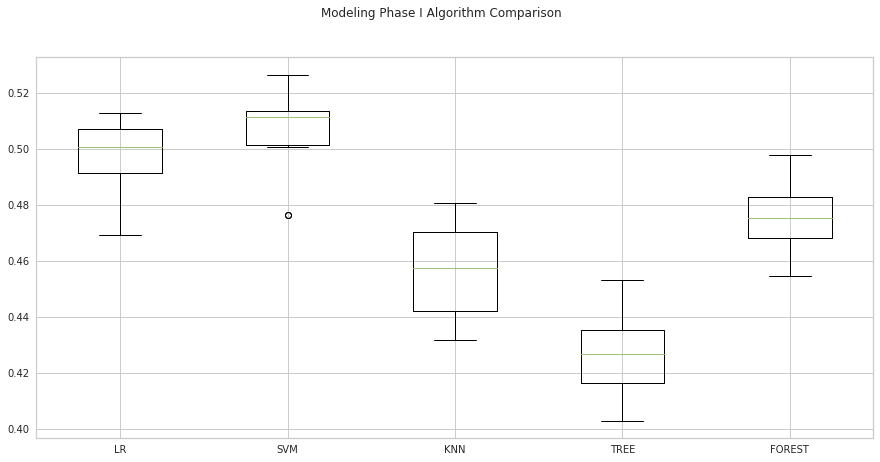

In [33]:
# Compare Algorithms
fig = plt.figure(figsize=(15,7))
fig.suptitle('Modeling Phase I Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Fine tune the SVM model

I will evaluate the SVM classifier from the pipeline with data fine tunning.

In [34]:
try:
    pipeline=None
    for n, m in pipelines:
        if n=='SVM':
            pipeline=m


    X_train=X_train.astype('float64')
    y_train=y_train.astype('float64')

except:
    logging.warning('Unable to run the SVM Classifier')

In [35]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'Scaler', 'Power', 'SVC', 'Scaler__copy', 'Scaler__with_mean', 'Scaler__with_std', 'Power__copy', 'Power__method', 'Power__standardize', 'SVC__C', 'SVC__cache_size', 'SVC__class_weight', 'SVC__coef0', 'SVC__decision_function_shape', 'SVC__degree', 'SVC__gamma', 'SVC__kernel', 'SVC__max_iter', 'SVC__probability', 'SVC__random_state', 'SVC__shrinking', 'SVC__tol', 'SVC__verbose'])

In [36]:
# distribution of target value for the validation set
kbest_df.loc[kbest_df['FLOWS_YEAR']==2020,['SRC_UID','TARGET']].groupby('TARGET').count()

,SRC_UID
TARGET,
-1,238
0,226
1,228


In [37]:
parameter_space = {
    'SVC__C': [0.01,1,100]
}

cv_model1 = GridSearchCV(pipeline, parameter_space, verbose=3)
cv_model1.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] SVC__C=0.01 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ......................... SVC__C=0.01, score=0.397, total=   2.7s
[CV] SVC__C=0.01 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV] ......................... SVC__C=0.01, score=0.404, total=   2.8s
[CV] SVC__C=0.01 .....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.5s remaining:    0.0s


[CV] ......................... SVC__C=0.01, score=0.365, total=   2.8s
[CV] SVC__C=1 ........................................................
[CV] ............................ SVC__C=1, score=0.418, total=   2.4s
[CV] SVC__C=1 ........................................................
[CV] ............................ SVC__C=1, score=0.425, total=   2.5s
[CV] SVC__C=1 ........................................................
[CV] ............................ SVC__C=1, score=0.467, total=   2.6s
[CV] SVC__C=100 ......................................................
[CV] .......................... SVC__C=100, score=0.389, total=   5.2s
[CV] SVC__C=100 ......................................................
[CV] .......................... SVC__C=100, score=0.387, total=   5.4s
[CV] SVC__C=100 ......................................................
[CV] .......................... SVC__C=100, score=0.413, total=   5.6s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   31.9s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('Scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('Power',
                                        PowerTransformer(copy=True,
                                                         method='yeo-johnson',
                                                         standardize=True)),
                                       ('SVC',
                                        SVC(C=1.0, cache_size=200,
                                            class_weight=None, coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='auto',
                                   

In [38]:
print("Best parameter (CV score=%0.3f):" % cv_model1.best_score_)
print(cv_model1.best_params_)
best_estimator = cv_model1.best_estimator_
y_pred=best_estimator.predict(X_validation)

Best parameter (CV score=0.437):
{'SVC__C': 1}


In [39]:
acc, conf = metrics_report(y_validation, y_pred)

Confusion Matrix

[[258  95  46]
 [155 164  81]
 [139  98 116]]

Accuracy: 0.47

Micro Precision: 0.47
Micro Recall: 0.47
Micro F1-score: 0.47

Macro Precision: 0.47
Macro Recall: 0.46
Macro F1-score: 0.46

Weighted Precision: 0.47
Weighted Recall: 0.47
Weighted F1-score: 0.46

Classification Report

              precision    recall  f1-score   support

   Out Flows       0.47      0.65      0.54       399
NeutralFlows       0.46      0.41      0.43       400
    In Flows       0.48      0.33      0.39       353

    accuracy                           0.47      1152
   macro avg       0.47      0.46      0.46      1152
weighted avg       0.47      0.47      0.46      1152



In [40]:
now = datetime.now()
filename = 'res/result--' + now.strftime("%m%d%Y%H%M%S") + '.res'
resultat=[now.strftime("%m%d%Y%H%M%S"),1,'MLP Classifier',pipeline,parameter_space,acc,conf,trans,'Fine tuning model 1 MLP Classifier. Nb features {} selected by SelectKBest'.format(n_features)]
r = pd.DataFrame(resultat)
r.T.to_csv(filename, header=None)


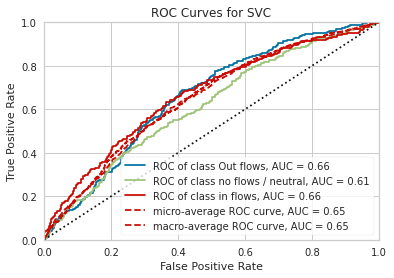

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for SVC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       binary=None, classes=None,
       encoder={-1: 'Out flows', 0: 'no flows / neutral', 1: 'in flows'},
       estimator=Pipeline(memory=None,
                          steps=[('Scaler',
                                  StandardScaler(copy=True, with_mean=True,
                                                 with_std=True)),
                                 ('Power',
                                  PowerTransformer(copy=True,
                                                   method='yeo-johnson',
                                                   standardize=True)),
                                 ('SVC',
                                  SVC(C=1, cache_size=200, class_weight=None,
                                      coef0=0.0, decision_function_shape='ovr',
                                      degree=3, gamma='auto', kernel='rbf',
                     

In [41]:
plot_ROC_curve(best_estimator, X_train, y_train, X_validation, y_validation)

### Fine Tune the RandomForest Classifier

As the RandomForest classifier got a good result compare to other classifier, I will also fine tune it with a grid search

In [42]:
pipeline=None
for n, m in pipelines:
    if n=='FOREST':
        pipeline=m


X_train=X_train.astype('float64')
y_train=y_train.astype('float64')



In [43]:
# Number of trees in random forest
n_estimators = [100,200,500]
max_features = ['auto', 'sqrt']
max_depth = [2,5,10,None]
# Create the random grid
parameter_space = {'FOREST__n_estimators': n_estimators,
                  'FOREST__max_features':max_features,
                  'FOREST__max_depth': max_depth,
                  #'FOREST__min_samples_split': [2,5,10],
                  'FOREST__bootstrap': [True,False]
                  }
logging.info('GridSearchCV - MODEL1 - RandomForest')
cv_model1 = GridSearchCV(pipeline, parameter_space, n_jobs=-1, verbose=3)
cv_model1.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % cv_model1.best_score_)
print(cv_model1.best_params_)
best_estimator = cv_model1.best_estimator_
y_pred=best_estimator.predict(X_validation)
acc, conf = metrics_report(y_validation, y_pred)
logging.info('MODEL1 - RandomForest - GridSearchCV -EVALUATED')

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 130 out of 144 | elapsed:   25.9s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   33.7s finished


Best parameter (CV score=0.380):
{'FOREST__bootstrap': True, 'FOREST__max_depth': 2, 'FOREST__max_features': 'auto', 'FOREST__n_estimators': 500}
Confusion Matrix

[[222   0 177]
 [172   0 228]
 [143   0 210]]

Accuracy: 0.38

Micro Precision: 0.38
Micro Recall: 0.38
Micro F1-score: 0.38

Macro Precision: 0.25
Macro Recall: 0.38
Macro F1-score: 0.30

Weighted Precision: 0.25
Weighted Recall: 0.38
Weighted F1-score: 0.30

Classification Report

              precision    recall  f1-score   support

   Out Flows       0.41      0.56      0.47       399
NeutralFlows       0.00      0.00      0.00       400
    In Flows       0.34      0.59      0.43       353

    accuracy                           0.38      1152
   macro avg       0.25      0.38      0.30      1152
weighted avg       0.25      0.38      0.30      1152



/home/dfelix/.venv/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dfelix/.venv/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dfelix/.venv/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


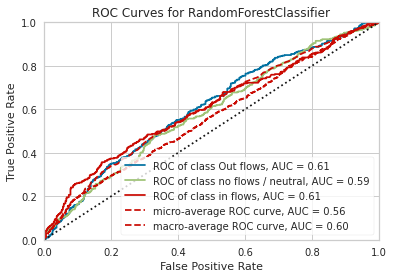

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       binary=None, classes=None,
       encoder={-1: 'Out flows', 0: 'no flows / neutral', 1: 'in flows'},
       estimator=Pipeline(memory=None,
                          steps=[('Scaler',
                                  StandardScaler(copy=True, with_mean=True,
                                                 with_std=True)),
                                 ('Power',
                                  PowerTransformer(copy=Tru...
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                   

In [44]:
plot_ROC_curve(best_estimator, X_train, y_train, X_validation, y_validation)

In [45]:
now = datetime.now()
filename = 'res/result--' + now.strftime("%m%d%Y%H%M%S") + '.res'
resultat=[now.strftime("%m%d%Y%H%M%S"),1,'Random Forest',pipeline,parameter_space,acc,conf,trans,'Fine tuning model 1 MLP Classifier. Nb features {} selected by SelectKBest'.format(n_features)]
r = pd.DataFrame(resultat)
r.T.to_csv(filename, header=None)


# Model 02
For the 2nd mmodeling process I will decide by myself which feature I want to transform and build the tranformation dictionary manually. I will use the same pipeline with the same estimator feeded with the transformed data.

I will start by creat group of features and then add them to the transformation dictionary.

Group will be:
- flows
- performances
- marketing & research

Last group will be fund caracteristics for which no custom transformation will be apply.

In [46]:
df.columns

Index(['SRC_UID', 'IS_STRATEGIC', 'ADMINSTRATION_FEES', 'MANAGEMENT_FEES',
       'MULTI_MANAGER_STRUCTURE', 'SOFTCLOSING', 'CNT_SHARE', 'QUANTITY',
       'IN_FLOWS', 'OUT_FLOWS', 'NET_FLOWS', 'AUM', 'BENCH_PERF_1_MONTH',
       'BENCH_PERF_1_YEAR', 'BENCH_PERF_3_MONTH', 'BENCH_PERF_6_MONTH',
       'BENCH_VOL_1_MONTH', 'BENCH_VOL_3_MONTH', 'BENCH_VOL_6_MONTH',
       'BENCH_VOLATILITY_1_YEAR', 'NAV_PERF_1_MONTH', 'NAV_PERF_1_YEAR',
       'NAV_PERF_3_MONTH', 'NAV_PERF_6_MONTH', 'NAV_VOL_1_MONTH',
       'NAV_VOL_3_MONTH', 'NAV_VOL_6_MONTH', 'NAV_VOLATILITY_1_YEAR',
       'BENCH_VOL_SINCE_INCEPT', 'NAV_PERF_COMPOUND_CREATION',
       'NAV_VOL_SINCE_INCEPT', 'FUND_SIZE', 'SUB_FUNDS_SHARE_PARTS',
       'SUB_FUNDS_SHARE_SIZE_SF_CCY', 'DOWNLOADED_DOCUMENTS', 'WEIGHTED',
       'PSU_SCORE', 'POSITIVE_RFP', 'EVENT_IMPACT', 'COMPUTED_FLOWS',
       'CHECKED', 'DIFF_FLOWS', 'THRESHOLD', 'TARGET', 'RISK_LEVEL_VALUE',
       'PRODUCT_STRATEGY', 'ASSET_NAME', 'FUND_NAME', 'STRATEGY_CAPABILITY'

In [47]:
cols_flows = ['IN_FLOWS', 'OUT_FLOWS','AUM']
cols_perfs = ['BENCH_PERF_SLOPE', 'BENCH_PERF_SLOPE_ERROR',
       'BENCH_VOL_SLOPE', 'BENCH_VOL_SLOPE_ERROR', 'NAV_PERF_SLOPE',
       'NAV_PERF_SLOPE_ERROR', 'NAV_VOL_SLOPE', 'NAV_VOL_SLOPE_ERROR']
cols_maktg = ['POSITIVE_RFP', 'EVENT_IMPACT', 'DOWNLOADED_DOCUMENTS','PSU_SCORE']
cols_funds = ['IS_STRATEGIC', 'ADMINSTRATION_FEES', 'MANAGEMENT_FEES','RISK_LEVEL_VALUE','STRATEGY_CAPABILITY','FUND_AGE']

## Create the transformation dictionary

For the flows and the performance, I will apply a rolling transformation. For the marketing I will evaluate expanding, shift & ewm.

In [48]:
trans = []
for i in range(len(cols_flows)):
    dico= {}
    dico['cols'] = [cols_flows[i]]
    dico['method'] = 'shift'
    dico['period'] = [1,2,3]
    dico['original'] = False
    trans.append(dico)
    

for i in range(len(cols_perfs)):
    dico= {}
    dico['cols'] = [cols_perfs[i]]
    dico['method'] = 'rolling'
    dico['period'] = [1,3,6]
    dico['original'] = False
    trans.append(dico)
    
for i in range(len(cols_maktg)):
    dico= {}
    dico['cols'] = [cols_maktg[i]]
    dico['method'] = 'ewm'
    dico['period'] = [1,3,6,9]
    dico['original'] = False
    trans.append(dico)

In [50]:

all_cols = cols_flows + cols_perfs + cols_maktg + cols_funds + ['SRC_UID','TARGET','FLOWS_YEAR','FLOWS_MONTH']

my_choice_df = df[all_cols].copy()

X = my_choice_df.drop(['TARGET','FLOWS_YEAR','FLOWS_MONTH'], axis=1)
y = my_choice_df.TARGET

In [51]:
# create the steps and the transformation Pipeline
steps = [('ts_2_supervised',myt.TS2Supervised(transformation=trans, breakdown=brk
                                          , verbose=False, interpolation=False))]
# create
mychoice_pipeline = Pipeline(steps)

mychoice_transformed_pipeline = mychoice_pipeline.fit_transform(X, y)


mychoice_df = mychoice_transformed_pipeline.merge(df[['TARGET','FLOWS_YEAR','FLOWS_MONTH']], left_index=True, right_index=True).copy()
mychoice_df.dropna(inplace=True)
mychoice_df

,IS_STRATEGIC,ADMINSTRATION_FEES,MANAGEMENT_FEES,RISK_LEVEL_VALUE,STRATEGY_CAPABILITY,FUND_AGE,SRC_UID,IN_FLOWS-s1,IN_FLOWS-s2,IN_FLOWS-s3,...,DOWNLOADED_DOCUMENTS-e3,DOWNLOADED_DOCUMENTS-e6,DOWNLOADED_DOCUMENTS-e9,PSU_SCORE-e1,PSU_SCORE-e3,PSU_SCORE-e6,PSU_SCORE-e9,TARGET,FLOWS_YEAR,FLOWS_MONTH
5,0,0.000277,0.001631,1,8,15.057534,206670688,65517596.0,104779215.0,68084125.0,...,50.486189,45.147240,43.078265,0.0,0.0,0.0,0.0,-1,2010,6
6,0,0.000277,0.001631,1,8,15.142466,206670688,43293193.0,65517596.0,104779215.0,...,62.174896,55.070827,52.263899,0.0,0.0,0.0,0.0,-1,2010,7
7,0,0.000277,0.001631,1,8,15.227397,206670688,33504675.0,43293193.0,65517596.0,...,74.350064,65.337771,61.699019,0.0,0.0,0.0,0.0,1,2010,8
8,0,0.000277,0.001631,1,8,15.309589,206670688,96312714.0,33504675.0,43293193.0,...,86.959309,75.936351,71.379555,0.0,0.0,0.0,0.0,1,2010,9
9,0,0.000277,0.001631,1,8,15.394521,206670688,202455177.0,96312714.0,33504675.0,...,99.951095,86.853855,81.300990,0.0,0.0,0.0,0.0,0,2010,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8897,1,0.000300,0.005000,3,9,2.917808,213479867994200,2226192.0,7838181.0,14258055.0,...,39.805275,39.011543,39.644003,0.0,0.0,0.0,0.0,1,2020,9
8898,1,0.000300,0.005000,3,9,3.002740,213479867994200,8479346.0,2226192.0,7838181.0,...,45.104083,42.163259,41.823799,0.0,0.0,0.0,0.0,1,2020,10
8899,1,0.000300,0.005000,3,9,3.084932,213479867994200,14776729.0,8479346.0,2226192.0,...,50.078151,45.435000,44.184497,0.0,0.0,0.0,0.0,1,2020,11
8900,1,0.000300,0.005000,3,9,3.169863,213479867994200,24501245.0,14776729.0,8479346.0,...,55.058680,48.952903,46.809153,0.0,0.0,0.0,0.0,1,2020,12


In [52]:
mychoice_df.columns

Index(['IS_STRATEGIC', 'ADMINSTRATION_FEES', 'MANAGEMENT_FEES',
       'RISK_LEVEL_VALUE', 'STRATEGY_CAPABILITY', 'FUND_AGE', 'SRC_UID',
       'IN_FLOWS-s1', 'IN_FLOWS-s2', 'IN_FLOWS-s3', 'OUT_FLOWS-s1',
       'OUT_FLOWS-s2', 'OUT_FLOWS-s3', 'AUM-s1', 'AUM-s2', 'AUM-s3',
       'BENCH_PERF_SLOPE-r1', 'BENCH_PERF_SLOPE-r3', 'BENCH_PERF_SLOPE-r6',
       'BENCH_PERF_SLOPE_ERROR-r1', 'BENCH_PERF_SLOPE_ERROR-r3',
       'BENCH_PERF_SLOPE_ERROR-r6', 'BENCH_VOL_SLOPE-r1', 'BENCH_VOL_SLOPE-r3',
       'BENCH_VOL_SLOPE-r6', 'BENCH_VOL_SLOPE_ERROR-r1',
       'BENCH_VOL_SLOPE_ERROR-r3', 'BENCH_VOL_SLOPE_ERROR-r6',
       'NAV_PERF_SLOPE-r1', 'NAV_PERF_SLOPE-r3', 'NAV_PERF_SLOPE-r6',
       'NAV_PERF_SLOPE_ERROR-r1', 'NAV_PERF_SLOPE_ERROR-r3',
       'NAV_PERF_SLOPE_ERROR-r6', 'NAV_VOL_SLOPE-r1', 'NAV_VOL_SLOPE-r3',
       'NAV_VOL_SLOPE-r6', 'NAV_VOL_SLOPE_ERROR-r1', 'NAV_VOL_SLOPE_ERROR-r3',
       'NAV_VOL_SLOPE_ERROR-r6', 'POSITIVE_RFP-e1', 'POSITIVE_RFP-e3',
       'POSITIVE_RFP-e6', 'POS

In [53]:
X_train, y_train, X_validation, y_validation, X_test, y_test, _, _ = split_dataset(mychoice_df)
X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape

((6789, 58), (6789,), (1152, 58), (1152,), (556, 58), (556,))

In [54]:
results, names = run_pipelines(X_train, y_train)
logging.info('MODEL-02 My Choice features and and custom transformation configuration files with {}'.format(len(all_cols)-4))
logging.info('Results: \n\n{}'.format(results))
logging.info('--------------------------------------------------------------------------------------------------')

100%|██████████| 5/5 [01:31<00:00, 18.24s/it]

['LR: 0.523061 (0.024157)', 'SVM: 0.544126 (0.031456)', 'KNN: 0.515251 (0.016527)', 'TREE: 0.447200 (0.021602)', 'FOREST: 0.510098 (0.022538)']


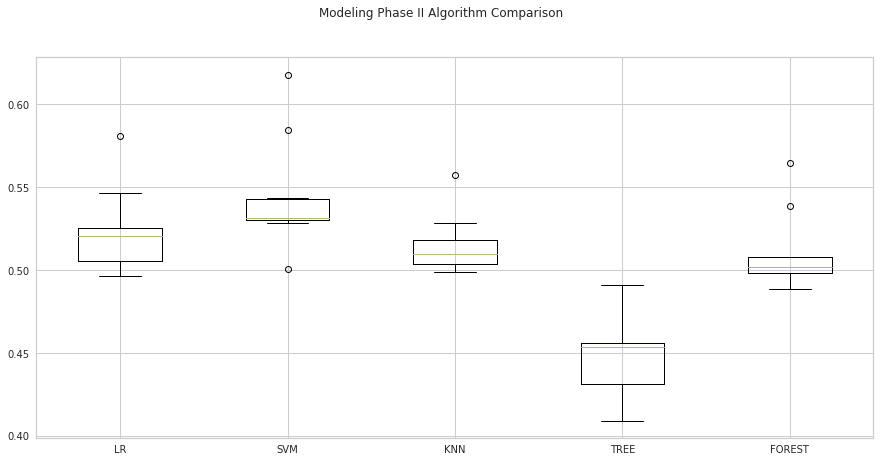

In [55]:
# Compare Algorithms
fig = plt.figure(figsize=(15,7))
fig.suptitle('Modeling Phase II Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Observation
The average score increase a little bit from the Model 01 (SelectKBest). I will iterate through classifier and tune parameter to have a better result.

### Fine Tune the K-Neighbors Classifier

Even the score is lower than the other I try to improve theresult by evaluating the model with a grid search and specific parameter

In [56]:
pipeline=None
for n, m in pipelines:
    if n=='KNN':
        pipeline=m


X_train=X_train.astype('float64')
y_train=y_train.astype('float64')

pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'Scaler', 'Power', 'KNN', 'Scaler__copy', 'Scaler__with_mean', 'Scaler__with_std', 'Power__copy', 'Power__method', 'Power__standardize', 'KNN__algorithm', 'KNN__leaf_size', 'KNN__metric', 'KNN__metric_params', 'KNN__n_jobs', 'KNN__n_neighbors', 'KNN__p', 'KNN__weights'])

In [57]:
# Create the random grid
parameter_space = {'KNN__n_neighbors': [50,100,300,500,1000],
                  'KNN__algorithm':['auto','brute'],
                   'KNN__p':[1,2]

                  }
logging.info('GridSearchCV - MODEL2 - Logistic Regression')
cv_model2_knn = GridSearchCV(pipeline, parameter_space, n_jobs=-1, verbose=3)
cv_model2_knn.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % cv_model2_knn.best_score_)
print(cv_model2_knn.best_params_)
best_estimator_knn = cv_model2_knn.best_estimator_
y_pred=best_estimator_knn.predict(X_validation)
acc, conf = metrics_report(y_validation, y_pred)
logging.info('MODEL2 - KNN - GridSearchCV -EVALUATED')

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  60 | elapsed:    6.4s remaining:   14.8s
[Parallel(n_jobs=-1)]: Done  39 out of  60 | elapsed:    7.7s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    8.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    8.6s finished


Best parameter (CV score=0.404):
{'KNN__algorithm': 'auto', 'KNN__n_neighbors': 1000, 'KNN__p': 2}
Confusion Matrix

[[275  77  47]
 [217 102  81]
 [213  34 106]]

Accuracy: 0.42

Micro Precision: 0.42
Micro Recall: 0.42
Micro F1-score: 0.42

Macro Precision: 0.44
Macro Recall: 0.41
Macro F1-score: 0.40

Weighted Precision: 0.44
Weighted Recall: 0.42
Weighted F1-score: 0.40

Classification Report

              precision    recall  f1-score   support

   Out Flows       0.39      0.69      0.50       399
NeutralFlows       0.48      0.26      0.33       400
    In Flows       0.45      0.30      0.36       353

    accuracy                           0.42      1152
   macro avg       0.44      0.41      0.40      1152
weighted avg       0.44      0.42      0.40      1152



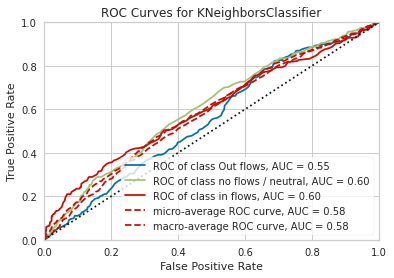

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       binary=None, classes=None,
       encoder={-1: 'Out flows', 0: 'no flows / neutral', 1: 'in flows'},
       estimator=Pipeline(memory=None,
                          steps=[('Scaler',
                                  StandardScaler(copy=True, with_mean=True,
                                                 with_std=True)),
                                 ('Power',
                                  PowerTransformer(copy=True,
                                                   method='yeo-johnson',
                                                   standardize=True)),
                                 ('KNN',
                                  KNeighborsClassifier(algorithm='auto',
                                                       leaf_size=30,
                                                       metric='minkowski',
                     

In [58]:
plot_ROC_curve(best_estimator_knn, X_train, y_train, X_validation, y_validation)

In [59]:
now = datetime.now()
filename = 'res/result--' + now.strftime("%m%d%Y%H%M%S") + '.res'
resultat=[now.strftime("%m%d%Y%H%M%S"),2,'Decision Tree',pipeline,parameter_space,acc,conf,trans,'Fine tuning model 2 KNN.']
r = pd.DataFrame(resultat)
r.T.to_csv(filename, header=None)


### Fine Tune the LogisticRegression

I will setup a parameter grid and run a GridSearch

In [60]:
pipeline=None
for n, m in pipelines:
    if n=='LR':
        pipeline=m


X_train=X_train.astype('float64')
y_train=y_train.astype('float64')

pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'Scaler', 'Power', 'LR', 'Scaler__copy', 'Scaler__with_mean', 'Scaler__with_std', 'Power__copy', 'Power__method', 'Power__standardize', 'LR__C', 'LR__class_weight', 'LR__dual', 'LR__fit_intercept', 'LR__intercept_scaling', 'LR__l1_ratio', 'LR__max_iter', 'LR__multi_class', 'LR__n_jobs', 'LR__penalty', 'LR__random_state', 'LR__solver', 'LR__tol', 'LR__verbose', 'LR__warm_start'])

In [61]:
# Create the random grid
parameter_space = {'LR__multi_class': ['auto','ovr'],
                  'LR__C':[0.0001, 0.001,0.01,1,100,1000,10000]

                  }
logging.info('GridSearchCV - MODEL2 - Logistic Regression')
cv_model2lr = GridSearchCV(pipeline, parameter_space, n_jobs=-1, verbose=3)
cv_model2lr.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % cv_model2lr.best_score_)
print(cv_model2lr.best_params_)
best_estimator_lr = cv_model2lr.best_estimator_
y_pred=best_estimator_lr.predict(X_validation)
acc, conf = metrics_report(y_validation, y_pred)
logging.info('MODEL2 - Logistic Regression - GridSearchCV -EVALUATED')

Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of  42 | elapsed:    3.1s remaining:   11.3s
[Parallel(n_jobs=-1)]: Done  24 out of  42 | elapsed:    4.7s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  39 out of  42 | elapsed:    8.9s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    9.1s finished


Best parameter (CV score=0.449):
{'LR__C': 1000, 'LR__multi_class': 'auto'}
Confusion Matrix

[[197  95 107]
 [ 97 160 143]
 [ 82  52 219]]

Accuracy: 0.50

Micro Precision: 0.50
Micro Recall: 0.50
Micro F1-score: 0.50

Macro Precision: 0.50
Macro Recall: 0.50
Macro F1-score: 0.50

Weighted Precision: 0.51
Weighted Recall: 0.50
Weighted F1-score: 0.50

Classification Report

              precision    recall  f1-score   support

   Out Flows       0.52      0.49      0.51       399
NeutralFlows       0.52      0.40      0.45       400
    In Flows       0.47      0.62      0.53       353

    accuracy                           0.50      1152
   macro avg       0.50      0.50      0.50      1152
weighted avg       0.51      0.50      0.50      1152



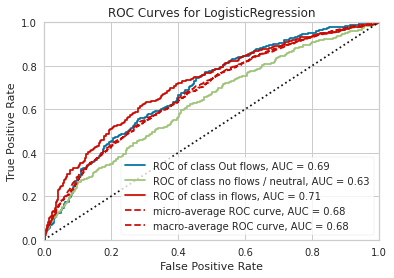

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       binary=None, classes=None,
       encoder={-1: 'Out flows', 0: 'no flows / neutral', 1: 'in flows'},
       estimator=Pipeline(memory=None,
                          steps=[('Scaler',
                                  StandardScaler(copy=True, with_mean=True,
                                                 with_std=True)),
                                 ('Power',
                                  PowerTransformer(copy=True,
                                                   me...
                                                   standardize=True)),
                                 ('LR',
                                  LogisticRegression(C=1000, class_weight=None,
                                                     dual=False,
                                                     fit_intercept=True,
                                       

In [62]:
plot_ROC_curve(best_estimator_lr, X_train, y_train, X_validation, y_validation)

In [63]:
now = datetime.now()
filename = 'res/result--' + now.strftime("%m%d%Y%H%M%S") + '.res'
resultat=[now.strftime("%m%d%Y%H%M%S"),2,'Decision Tree',pipeline,parameter_space,acc,conf,trans,'Fine tuning model 2 KNN.']
r = pd.DataFrame(resultat)
r.T.to_csv(filename, header=None)


## Decision Tree Classifier

It's seems I have good prognose result with the Decision Tree Classifier. Let's try to improve the result.

In [64]:
pipeline=None
for n, m in pipelines:
    if n=='TREE':
        pipeline=m


X_train=X_train.astype('float64')
y_train=y_train.astype('float64')

pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'Scaler', 'Power', 'TREE', 'Scaler__copy', 'Scaler__with_mean', 'Scaler__with_std', 'Power__copy', 'Power__method', 'Power__standardize', 'TREE__class_weight', 'TREE__criterion', 'TREE__max_depth', 'TREE__max_features', 'TREE__max_leaf_nodes', 'TREE__min_impurity_decrease', 'TREE__min_impurity_split', 'TREE__min_samples_leaf', 'TREE__min_samples_split', 'TREE__min_weight_fraction_leaf', 'TREE__presort', 'TREE__random_state', 'TREE__splitter'])

In [65]:
# Create the random grid
parameter_space = {'TREE__criterion': ['gini','entropy'],
                  'TREE__max_depth':[None,5,10,15,20,50],
                   'TREE__splitter':['best','random'],
                   'TREE__max_features':['auto','sqrt','log2']

                  }
logging.info('GridSearchCV - MODEL2 - Decision Tree')
cv_model2 = GridSearchCV(pipeline, parameter_space, n_jobs=-1, verbose=3)
cv_model2.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % cv_model2.best_score_)
print(cv_model2.best_params_)
best_estimator_tree = cv_model2.best_estimator_
y_pred=best_estimator_tree.predict(X_validation)
acc, conf = metrics_report(y_validation, y_pred)
logging.info('MODEL2 - DecisionTree - GridSearchCV -EVALUATED')

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:    9.4s finished


Best parameter (CV score=0.381):
{'TREE__criterion': 'entropy', 'TREE__max_depth': 10, 'TREE__max_features': 'log2', 'TREE__splitter': 'random'}
Confusion Matrix

[[172 137  90]
 [118 194  88]
 [118 103 132]]

Accuracy: 0.43

Micro Precision: 0.43
Micro Recall: 0.43
Micro F1-score: 0.43

Macro Precision: 0.43
Macro Recall: 0.43
Macro F1-score: 0.43

Weighted Precision: 0.43
Weighted Recall: 0.43
Weighted F1-score: 0.43

Classification Report

              precision    recall  f1-score   support

   Out Flows       0.42      0.43      0.43       399
NeutralFlows       0.45      0.48      0.47       400
    In Flows       0.43      0.37      0.40       353

    accuracy                           0.43      1152
   macro avg       0.43      0.43      0.43      1152
weighted avg       0.43      0.43      0.43      1152



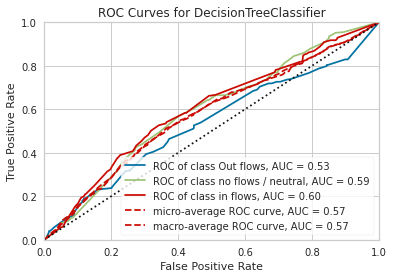

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       binary=None, classes=None,
       encoder={-1: 'Out flows', 0: 'no flows / neutral', 1: 'in flows'},
       estimator=Pipeline(memory=None,
                          steps=[('Scaler',
                                  StandardScaler(copy=True, with_mean=True,
                                                 with_std=True)),
                                 ('Power',
                                  PowerTransformer(copy=Tru...
                                  DecisionTreeClassifier(class_weight=None,
                                                         criterion='entropy',
                                                         max_depth=10,
                                                         max_features='log2',
                                                         max_leaf_nodes=None,
                                       

In [66]:
plot_ROC_curve(best_estimator_tree, X_train, y_train, X_validation, y_validation)

In [67]:
now = datetime.now()
filename = 'res/result--' + now.strftime("%m%d%Y%H%M%S") + '.res'
resultat=[now.strftime("%m%d%Y%H%M%S"),2,'Decision Tree',pipeline,parameter_space,acc,conf,trans,'Fine tuning model 2 Decision Tree.']
r = pd.DataFrame(resultat)
r.T.to_csv(filename, header=None)


### Fine Tune the SVM Classifier

In [68]:
pipeline=None
for n, m in pipelines:
    if n=='SVM':
        pipeline=m


X_train=X_train.astype('float64')
y_train=y_train.astype('float64')

pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'Scaler', 'Power', 'SVC', 'Scaler__copy', 'Scaler__with_mean', 'Scaler__with_std', 'Power__copy', 'Power__method', 'Power__standardize', 'SVC__C', 'SVC__cache_size', 'SVC__class_weight', 'SVC__coef0', 'SVC__decision_function_shape', 'SVC__degree', 'SVC__gamma', 'SVC__kernel', 'SVC__max_iter', 'SVC__probability', 'SVC__random_state', 'SVC__shrinking', 'SVC__tol', 'SVC__verbose'])

In [69]:
# Create the random grid
parameter_space = {'SVC__C':[0.001, 0.1,1,10,100],
                   'SVC__kernel':['linear','poly','sigmoid'],
                   'SVC__degree':[3,5,9]
                  }
logging.info('GridSearchCV - MODEL2 - SVC')
cv_model2 = GridSearchCV(pipeline, parameter_space, n_jobs=-1, verbose=3)
cv_model2.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % cv_model2.best_score_)
print(cv_model2.best_params_)
best_estimator_tree = cv_model2.best_estimator_
y_pred=best_estimator_tree.predict(X_validation)
acc, conf = metrics_report(y_validation, y_pred)
logging.info('MODEL2 - SVC - GridSearchCV -EVALUATED')

Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 118 out of 135 | elapsed:   45.0s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  3.9min finished


Best parameter (CV score=0.439):
{'SVC__C': 1, 'SVC__degree': 3, 'SVC__kernel': 'linear'}
Confusion Matrix

[[251  80  68]
 [152 131 117]
 [126  50 177]]

Accuracy: 0.49

Micro Precision: 0.49
Micro Recall: 0.49
Micro F1-score: 0.49

Macro Precision: 0.49
Macro Recall: 0.49
Macro F1-score: 0.48

Weighted Precision: 0.49
Weighted Recall: 0.49
Weighted F1-score: 0.48

Classification Report

              precision    recall  f1-score   support

   Out Flows       0.47      0.63      0.54       399
NeutralFlows       0.50      0.33      0.40       400
    In Flows       0.49      0.50      0.50       353

    accuracy                           0.49      1152
   macro avg       0.49      0.49      0.48      1152
weighted avg       0.49      0.49      0.48      1152



# Model 03

In [88]:
trans = []
for i in range(len(cols_flows)):
    dico= {}
    dico['cols'] = [cols_flows[i]]
    dico['method'] = 'rolling'
    dico['period'] = [2,3,6]
    dico['original'] = False
    trans.append(dico)
    

for i in range(len(cols_perfs)):
    dico= {}
    dico['cols'] = [cols_perfs[i]]
    dico['method'] = 'shift'
    dico['period'] = [2,3,5]
    dico['original'] = False
    trans.append(dico)
    
for i in range(len(cols_maktg)):
    dico= {}
    dico['cols'] = [cols_maktg[i]]
    dico['method'] = 'expnading'
    dico['period'] = [3,6,9]
    dico['original'] = False
    trans.append(dico)

In [89]:

all_cols = cols_flows + cols_perfs + cols_maktg + cols_funds + ['SRC_UID','TARGET','FLOWS_YEAR','FLOWS_MONTH']

my_choice_df_model_3 = df[all_cols].copy()

X = my_choice_df_model_3.drop(['TARGET','FLOWS_YEAR','FLOWS_MONTH'], axis=1)
y = my_choice_df_model_3.TARGET

In [90]:
# create the steps and the transformation Pipeline
steps = [('ts_2_supervised',myt.TS2Supervised(transformation=trans, breakdown=brk
                                          , verbose=False, interpolation=False))]
# create
mychoice_pipeline_3 = Pipeline(steps)

mychoice_transformed_pipeline_3 = mychoice_pipeline_3.fit_transform(X, y)


my_choice_df_model_3 = mychoice_transformed_pipeline_3.merge(df[['TARGET','FLOWS_YEAR','FLOWS_MONTH']], left_index=True, right_index=True).copy()
my_choice_df_model_3.dropna(inplace=True)
my_choice_df_model_3

,IS_STRATEGIC,ADMINSTRATION_FEES,MANAGEMENT_FEES,RISK_LEVEL_VALUE,STRATEGY_CAPABILITY,FUND_AGE,SRC_UID,IN_FLOWS-r2,IN_FLOWS-r3,IN_FLOWS-r6,...,NAV_PERF_SLOPE_ERROR-s5,NAV_VOL_SLOPE-s2,NAV_VOL_SLOPE-s3,NAV_VOL_SLOPE-s5,NAV_VOL_SLOPE_ERROR-s2,NAV_VOL_SLOPE_ERROR-s3,NAV_VOL_SLOPE_ERROR-s5,TARGET,FLOWS_YEAR,FLOWS_MONTH
5,0,0.000277,0.001631,1,8,15.057534,206670688,54405394.5,7.119667e+07,7.345858e+07,...,0.004775,-0.000082,-0.000106,-0.000154,0.000607,0.000647,0.000694,-1,2010,6
6,0,0.000277,0.001631,1,8,15.142466,206670688,38398934.0,4.743849e+07,6.743118e+07,...,0.003938,-0.000062,-0.000082,-0.000127,0.000610,0.000607,0.000652,-1,2010,7
7,0,0.000277,0.001631,1,8,15.227397,206670688,64908694.5,5.770353e+07,6.858192e+07,...,0.003630,-0.000040,-0.000062,-0.000106,0.000655,0.000610,0.000647,1,2010,8
8,0,0.000277,0.001631,1,8,15.309589,206670688,149383945.5,1.107575e+08,9.097710e+07,...,0.002517,-0.000024,-0.000040,-0.000082,0.000736,0.000655,0.000607,1,2010,9
9,0,0.000277,0.001631,1,8,15.394521,206670688,159407637.5,1.383760e+08,9.290724e+07,...,0.001721,-0.000059,-0.000024,-0.000062,0.000741,0.000736,0.000610,0,2010,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8897,1,0.000300,0.005000,3,9,2.917808,213479867994200,5352769.0,6.181240e+06,7.525536e+06,...,0.011942,-0.013975,-0.009852,0.018318,0.083748,0.074113,0.087565,1,2020,9
8898,1,0.000300,0.005000,3,9,3.002740,213479867994200,11628037.5,8.494089e+06,9.043410e+06,...,0.024880,-0.015355,-0.013975,-0.008385,0.083688,0.083748,0.109741,1,2020,10
8899,1,0.000300,0.005000,3,9,3.084932,213479867994200,19638987.0,1.591911e+07,1.201329e+07,...,0.026200,-0.001291,-0.015355,-0.009852,0.055365,0.083688,0.074113,1,2020,11
8900,1,0.000300,0.005000,3,9,3.169863,213479867994200,34187840.5,2.771747e+07,1.694935e+07,...,0.039523,-0.012080,-0.001291,-0.013975,0.070153,0.055365,0.083748,1,2020,12


In [91]:
X_train, y_train, X_validation, y_validation, X_test, y_test, _, _ = split_dataset(my_choice_df_model_3)
X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape

((6789, 42), (6789,), (1152, 42), (1152,), (556, 42), (556,))

In [92]:
results, names = run_pipelines(X_train, y_train)
logging.info('MODEL-03 My Choice features with rolling on FLOWS {}'.format(len(all_cols)-4))
logging.info('Results: \n\n{}'.format(results))
logging.info('--------------------------------------------------------------------------------------------------')

100%|██████████| 5/5 [01:04<00:00, 12.86s/it]

['LR: 0.692451 (0.025652)', 'SVM: 0.645174 (0.033915)', 'KNN: 0.541915 (0.024444)', 'TREE: 0.580352 (0.017350)', 'FOREST: 0.609377 (0.024620)']


# Evaluate a configuration transformation

The Time Series dataset can be transformed with my Custome Transformer by applying windowing to features. To recall, the methods are shift, rolling, expanding and ewm (exponential weighted).

The function bellow receives a configuration paramter set, transforms the Time Series dataset to a supervised learning dataset, splits the data (2010 - mid-2019, mid-2019 to mid-2020, mid-2020 to now) and finally runs the pipeline with differents classifiers.



In [164]:
show_boxplot=False

In [165]:
def plot_evaluation(results, names):
    # Compare Algorithms
    fig = plt.figure(figsize=(15,7))
    fig.suptitle('Modeling Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

def evaluate_transformation_TS_2_SL(config, cols, interpolate, show_plot):
    evaluated_df = df[cols].copy()

    X = evaluated_df.drop(['TARGET','FLOWS_YEAR','FLOWS_MONTH'], axis=1)
    y = evaluated_df.TARGET
    
    # create the steps and the transformation Pipeline
    steps = [('ts_2_supervised',myt.TS2Supervised(transformation=config, breakdown=brk
                                              , verbose=False, interpolation=interpolate))]
    # create
    evaluated_pipeline = Pipeline(steps)

    evaluated_transformed_pipeline = evaluated_pipeline.fit_transform(X, y)


    evaluated_df = evaluated_transformed_pipeline.merge(df[['TARGET','FLOWS_YEAR','FLOWS_MONTH']], left_index=True, right_index=True).copy()
    evaluated_df.dropna(inplace=True)
    evaluated_df    
    
    X_train, y_train, X_validation, y_validation, X_test, y_test, _, _ = split_dataset(evaluated_df)
    print(X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape)
    
    results, names = run_pipelines(X_train, y_train)
    logging.info('MODEL-Evaluated My Choice features with rolling on FLOWS {}'.format(len(all_cols)-4))
    logging.info('Results: \n\n{}'.format(results))
    logging.info('--------------------------------------------------------------------------------------------------') 
    
    if show_plot:
        plot_evaluation(results, names)
    
    return results, names

In [166]:
global_results_set = []

## Transformer n° 1 -- SelectKBest --
For the 1st transformer I will work with sklearn SelectKBest to identify x best features and evalute classifiers.

In [167]:
n_features_list=[5,15,35]

for n_features in n_features_list:
    # define the X vector and y target for the new temprary dataset
    features_df = df.drop(['NET_FLOWS','COMPUTED_FLOWS','SRC_UID','THRESHOLD'], axis=1).copy()
    target = df.TARGET

    X_train, y_train, X_validation, y_validation, X_test, y_test, _, _ = split_dataset(features_df)
    # X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape

    # Create and fit selector

    selector = SelectKBest(f_classif, k=n_features)

    # selector.fit(features_df, target)
    selector.fit(X_train, y_train)
    # Get columns to keep and create new dataframe with those only
    cols = selector.get_support(indices=True)
    

    features_df_new = features_df.iloc[:,cols]
    
    try:
        features_df_new.drop('SRC_UID',axis=1, inplace=True)
    except:
        None
    try:
        features_df_new.drop('TARGET',axis=1, inplace=True)
    except:
        None

    features_df_new=features_df_new.merge(df[['SRC_UID','TARGET']], left_index=True, right_index=True)

    cols_config=features_df_new.drop(['SRC_UID','TARGET'],axis=1).columns.tolist()
    
    print(cols_config)
    if 'FLOWS_MONTH' in cols_config:
        cols_config.remove('FLOWS_MONTH')
    if 'FLOWS_YEAR' in cols_config:
        cols_config.remove('FLOWS_YEAR')
        


    X = features_df_new.drop('TARGET', axis=1)
    y = features_df_new.TARGET

    trans = []
    for i in range(len(cols_config)):
        dico= {}
        dico['cols'] = [cols_config[i]]
        dico['method'] = 'rolling'
        dico['period'] = [2,3,6]
        dico['original'] = False
        trans.append(dico)

    trans
    eval_cols=features_df_new.columns.tolist()
    eval_cols.append('FLOWS_YEAR')
    eval_cols.append('FLOWS_MONTH')

    r, n = evaluate_transformation_TS_2_SL(trans, eval_cols, False, show_boxplot)
    i=0
    for j in r:
        global_results_set.append([names[i], j.mean(), trans, all_cols,'{} features SelectKBest'.format(n_features)])
        i=i+1

['IN_FLOWS', 'NAV_PERF_1_YEAR', 'NAV_PERF_3_MONTH', 'NAV_PERF_6_MONTH', 'NAV_PERF_SLOPE']


  0%|          | 0/2 [00:00<?, ?it/s]

(6789, 18) (6789,) (1152, 18) (1152,) (556, 18) (556,)


100%|██████████| 2/2 [00:06<00:00,  3.12s/it]


['LR: 0.515688 (0.015795)', 'TREE: 0.451469 (0.015741)']
['IN_FLOWS', 'OUT_FLOWS', 'BENCH_PERF_1_YEAR', 'BENCH_PERF_3_MONTH', 'BENCH_PERF_6_MONTH', 'NAV_PERF_1_MONTH', 'NAV_PERF_1_YEAR', 'NAV_PERF_3_MONTH', 'NAV_PERF_6_MONTH', 'NAV_PERF_COMPOUND_CREATION', 'RISK_LEVEL_VALUE', 'FLOWS_QUARTER', 'BENCH_PERF_SLOPE', 'BENCH_VOL_SLOPE_ERROR', 'NAV_PERF_SLOPE']


  0%|          | 0/2 [00:00<?, ?it/s]

(6789, 48) (6789,) (1152, 48) (1152,) (556, 48) (556,)


100%|██████████| 2/2 [00:17<00:00,  8.65s/it]
/home/dfelix/.venv/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


['LR: 0.666375 (0.019477)', 'TREE: 0.566362 (0.015229)']
['IS_STRATEGIC', 'ADMINSTRATION_FEES', 'MANAGEMENT_FEES', 'MULTI_MANAGER_STRUCTURE', 'SOFTCLOSING', 'CNT_SHARE', 'IN_FLOWS', 'OUT_FLOWS', 'AUM', 'BENCH_PERF_1_MONTH', 'BENCH_PERF_1_YEAR', 'BENCH_PERF_3_MONTH', 'BENCH_PERF_6_MONTH', 'BENCH_VOL_1_MONTH', 'BENCH_VOL_3_MONTH', 'BENCH_VOL_6_MONTH', 'NAV_PERF_1_MONTH', 'NAV_PERF_1_YEAR', 'NAV_PERF_3_MONTH', 'NAV_PERF_6_MONTH', 'NAV_VOL_1_MONTH', 'NAV_VOL_3_MONTH', 'NAV_VOL_6_MONTH', 'NAV_PERF_COMPOUND_CREATION', 'NAV_VOL_SINCE_INCEPT', 'POSITIVE_RFP', 'RISK_LEVEL_VALUE', 'FLOWS_MONTH', 'FLOWS_QUARTER', 'FUND_AGE', 'BENCH_PERF_SLOPE', 'BENCH_VOL_SLOPE_ERROR', 'NAV_PERF_SLOPE', 'NAV_VOL_SLOPE']


  0%|          | 0/2 [00:00<?, ?it/s]

(6789, 102) (6789,) (1152, 102) (1152,) (556, 102) (556,)


100%|██████████| 2/2 [00:39<00:00, 19.89s/it]

['LR: 0.693627 (0.022733)', 'TREE: 0.580943 (0.020260)']


## Transformer n° 2 -- My choice of columns --
Based on my business area knowledge I selected columns and decided which rolling windows method to apply.

In [168]:
cols_flows = ['IN_FLOWS', 'OUT_FLOWS','AUM']
cols_perfs = ['BENCH_PERF_SLOPE', 'BENCH_PERF_SLOPE_ERROR',
       'BENCH_VOL_SLOPE', 'BENCH_VOL_SLOPE_ERROR', 'NAV_PERF_SLOPE',
       'NAV_PERF_SLOPE_ERROR', 'NAV_VOL_SLOPE', 'NAV_VOL_SLOPE_ERROR']
cols_maktg = ['POSITIVE_RFP', 'EVENT_IMPACT', 'DOWNLOADED_DOCUMENTS','PSU_SCORE']
cols_funds = ['IS_STRATEGIC', 'ADMINSTRATION_FEES', 'MANAGEMENT_FEES','RISK_LEVEL_VALUE','STRATEGY_CAPABILITY','FUND_AGE']

In [170]:
trans = []
for i in range(len(cols_flows)):
    dico= {}
    dico['cols'] = [cols_flows[i]]
    dico['method'] = 'rolling'
    dico['period'] = [2,3,6]
    dico['original'] = False
    trans.append(dico)
    

for i in range(len(cols_perfs)):
    dico= {}
    dico['cols'] = [cols_perfs[i]]
    dico['method'] = 'shift'
    dico['period'] = [2,3,5]
    dico['original'] = False
    trans.append(dico)
    
for i in range(len(cols_maktg)):
    dico= {}
    dico['cols'] = [cols_maktg[i]]
    dico['method'] = 'expnading'
    dico['period'] = [3,6,9]
    dico['original'] = False
    trans.append(dico)
r, n = evaluate_transformation_TS_2_SL(trans, all_cols, False, show_boxplot)
i=0
for j in r:
    global_results_set.append([names[i], j.mean(), trans, all_cols,'My 1st choice of columns'])
    i=i+1

  0%|          | 0/2 [00:00<?, ?it/s]

(6789, 42) (6789,) (1152, 42) (1152,) (556, 42) (556,)


100%|██████████| 2/2 [00:15<00:00,  7.83s/it]

['LR: 0.692451 (0.025652)', 'TREE: 0.580352 (0.017350)']


In [171]:
pd.DataFrame(global_results_set, columns=['classifier','scores','transformer','columns','notes']).sort_values('scores', ascending=False)

,classifier,scores,transformer,columns,notes
4,LR,0.693627,"[{'cols': ['IS_STRATEGIC'], 'method': 'rolling...","[IN_FLOWS, OUT_FLOWS, AUM, BENCH_PERF_SLOPE, B...",35 features SelectKBest
6,LR,0.692451,"[{'cols': ['IN_FLOWS'], 'method': 'rolling', '...","[IN_FLOWS, OUT_FLOWS, AUM, BENCH_PERF_SLOPE, B...",My 1st choice of columns
2,LR,0.666375,"[{'cols': ['IN_FLOWS'], 'method': 'rolling', '...","[IN_FLOWS, OUT_FLOWS, AUM, BENCH_PERF_SLOPE, B...",15 features SelectKBest
5,SVM,0.580943,"[{'cols': ['IS_STRATEGIC'], 'method': 'rolling...","[IN_FLOWS, OUT_FLOWS, AUM, BENCH_PERF_SLOPE, B...",35 features SelectKBest
7,SVM,0.580352,"[{'cols': ['IN_FLOWS'], 'method': 'rolling', '...","[IN_FLOWS, OUT_FLOWS, AUM, BENCH_PERF_SLOPE, B...",My 1st choice of columns
3,SVM,0.566362,"[{'cols': ['IN_FLOWS'], 'method': 'rolling', '...","[IN_FLOWS, OUT_FLOWS, AUM, BENCH_PERF_SLOPE, B...",15 features SelectKBest
0,LR,0.515688,"[{'cols': ['IN_FLOWS'], 'method': 'rolling', '...","[IN_FLOWS, OUT_FLOWS, AUM, BENCH_PERF_SLOPE, B...",5 features SelectKBest
1,SVM,0.451469,"[{'cols': ['IN_FLOWS'], 'method': 'rolling', '...","[IN_FLOWS, OUT_FLOWS, AUM, BENCH_PERF_SLOPE, B...",5 features SelectKBest


# Model Selection and Overfitting

I wull work with the best model from the 2nd phase of medeling and save it to be bale to work with my test set which is "pure". I will now check for overfitting.

In [70]:
model_choosen = best_estimator_lr

In [71]:
       
model_choosen.fit(X_train, y_train)
# evaluate on the train dataset
y_pred = model_choosen.predict(X_validation)
acc, conf = metrics_report(y_validation, y_pred)
logging.info('MODEL2 - DecisionTree - GridSearchCV -EVALUATED')

Confusion Matrix

[[197  95 107]
 [ 97 160 143]
 [ 82  52 219]]

Accuracy: 0.50

Micro Precision: 0.50
Micro Recall: 0.50
Micro F1-score: 0.50

Macro Precision: 0.50
Macro Recall: 0.50
Macro F1-score: 0.50

Weighted Precision: 0.51
Weighted Recall: 0.50
Weighted F1-score: 0.50

Classification Report

              precision    recall  f1-score   support

   Out Flows       0.52      0.49      0.51       399
NeutralFlows       0.52      0.40      0.45       400
    In Flows       0.47      0.62      0.53       353

    accuracy                           0.50      1152
   macro avg       0.50      0.50      0.50      1152
weighted avg       0.51      0.50      0.50      1152



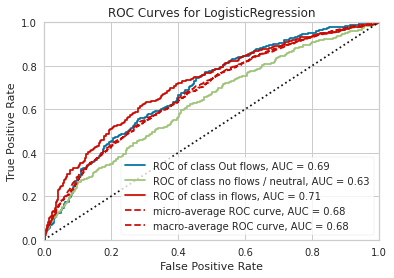

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       binary=None, classes=None,
       encoder={-1: 'Out flows', 0: 'no flows / neutral', 1: 'in flows'},
       estimator=Pipeline(memory=None,
                          steps=[('Scaler',
                                  StandardScaler(copy=True, with_mean=True,
                                                 with_std=True)),
                                 ('Power',
                                  PowerTransformer(copy=True,
                                                   me...
                                                   standardize=True)),
                                 ('LR',
                                  LogisticRegression(C=1000, class_weight=None,
                                                     dual=False,
                                                     fit_intercept=True,
                                       

In [72]:
plot_ROC_curve(best_estimator_lr, X_train, y_train, X_validation, y_validation)

In [73]:
best_estimator_lr

Pipeline(memory=None,
         steps=[('Scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('Power',
                 PowerTransformer(copy=True, method='yeo-johnson',
                                  standardize=True)),
                ('LR',
                 LogisticRegression(C=1000, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

# Model Finalization

I will finalize the model before saving, working with a Logistic Regression and the set of data decided by me (my choices)


In [74]:
X_train.shape, X_validation.shape, X_test.shape

((6789, 58), (1152, 58), (556, 58))

In [75]:
y_train.shape, y_validation.shape, y_test.shape

((6789,), (1152,), (556,))